In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import sknetwork as sn
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as AMI
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from fstar import fstar
from partition_sknetwork import ECG

from cove import COVE
from cove.dimension_reduction import LaplacianEigenmap, UMAPLE
from utils import *

import time
import gc

In [2]:
import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning
import sklearn.utils.deprecation

warnings.simplefilter("ignore", category=NumbaExperimentalFeatureWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
n = 5000
RUNS = 10
xis = np.linspace(0.1, 0.7, 25)
n_walks = 10
walk_len = 40
window_size=7
dim=2 # 16, 128

methods = ["COVE+UMAP", "COVE+UMAPLE", "COVE+SVD", "N2V", "N2V+UMAP", "Louvain", "ECG"]

In [5]:
np.random.seed(42)

vectorizer = COVE(window_length=window_size, walks_per_node = n_walks, walk_length = walk_len)
umap = UMAP(n_components=dim, metric="hellinger")
umaple = UMAPLE(dimension=dim, metric="hellinger")
svd = TruncatedSVD(n_components=dim)
clusterer = HDBSCAN()
louvain = sn.clustering.Louvain()
ecg = ECG()

performance = np.zeros((2, 7, len(xis), RUNS), dtype="float64")
ami = np.zeros((7, len(xis), RUNS), dtype="float64")
with tqdm(total=len(xis)*RUNS) as pbar:
    for i, xi in enumerate(xis):            
        for j in range(RUNS):
            adjacency, labels = abcd(n, xi)
            kmeans = KMeans(n_clusters=np.max(labels)+1)

            high = vectorizer.fit(adjacency).cooccurance_csr_
            low = umap.fit_transform(high)
            performance[0, 0, i, j] = fstar(clusterer.fit_predict(low), labels)
            km = kmeans.fit_predict(low)
            performance[1, 0, i, j] = fstar(km, labels)
            ami[0, i, j] = AMI(km, labels)

            low = umaple.fit_transform(high, adjacency)
            performance[0, 1, i, j] = fstar(clusterer.fit_predict(low), labels)
            km = kmeans.fit_predict(low)
            performance[1, 1, i, j] = fstar(km, labels)
            ami[0, i, j] = AMI(km, labels)

            low = svd.fit_transform(high)
            performance[0, 2, i, j] = fstar(clusterer.fit_predict(low), labels)
            km = kmeans.fit_predict(low)
            performance[1, 2, i, j] = fstar(km, labels)
            ami[0, i, j] = AMI(km, labels)

            low = node2vec(adjacency, dim, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
            performance[0, 3, i, j] = fstar(clusterer.fit_predict(low), labels)
            km = kmeans.fit_predict(low)
            performance[1, 3, i, j] = fstar(km, labels)
            ami[0, i, j] = AMI(km, labels)

            high = node2vec(adjacency, 128, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
            low = UMAP(n_components=dim, metric="cosine").fit_transform(high)
            performance[0, 4, i, j] = fstar(clusterer.fit_predict(low), labels)
            km = kmeans.fit_predict(low)
            performance[1, 4, i, j] = fstar(km, labels)
            ami[0, i, j] = AMI(km, labels)

            predict = louvain.fit_predict(adjacency)
            performance[0, 5, i, j] = fstar(predict, labels)
            performance[1, 5, i, j] = fstar(predict, labels)
            ami[0, i, j] = AMI(predict, labels)

            predict = ecg.fit_predict(adjacency)
            performance[0, 6, i, j] = fstar(predict, labels)
            performance[1, 6, i, j] = fstar(predict, labels)
            ami[0, i, j] = AMI(predict, labels)
            pbar.update()
    np.save(f"clustering_performance_dim{dim}_cp.npy", performance)
    np.save(f"clustering_ami_dim{dim}_cp.npy", ami)


np.save(f"clustering_performance_dim{dim}.npy", performance)
np.save(f"clustering_ami_dim{dim}.npy", performance)
print("Simulation Finished")

  0%|          | 0/250 [00:00<?, ?it/s]

/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:290: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  return super().__call__(*args, **kws)
/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:290: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  return super().__call__(*args, **kws)
  0%|          | 1/250 [00:50<3:29:07, 50.39s/it]/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:290: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  return super().__call__(*args, **kws)
/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:290: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  return super().__call__(*args, **kws)
  1%|          | 2/250 [01:24<2:48:31, 40.77s/it]/Users/ryandewolfe

Simulation Finished


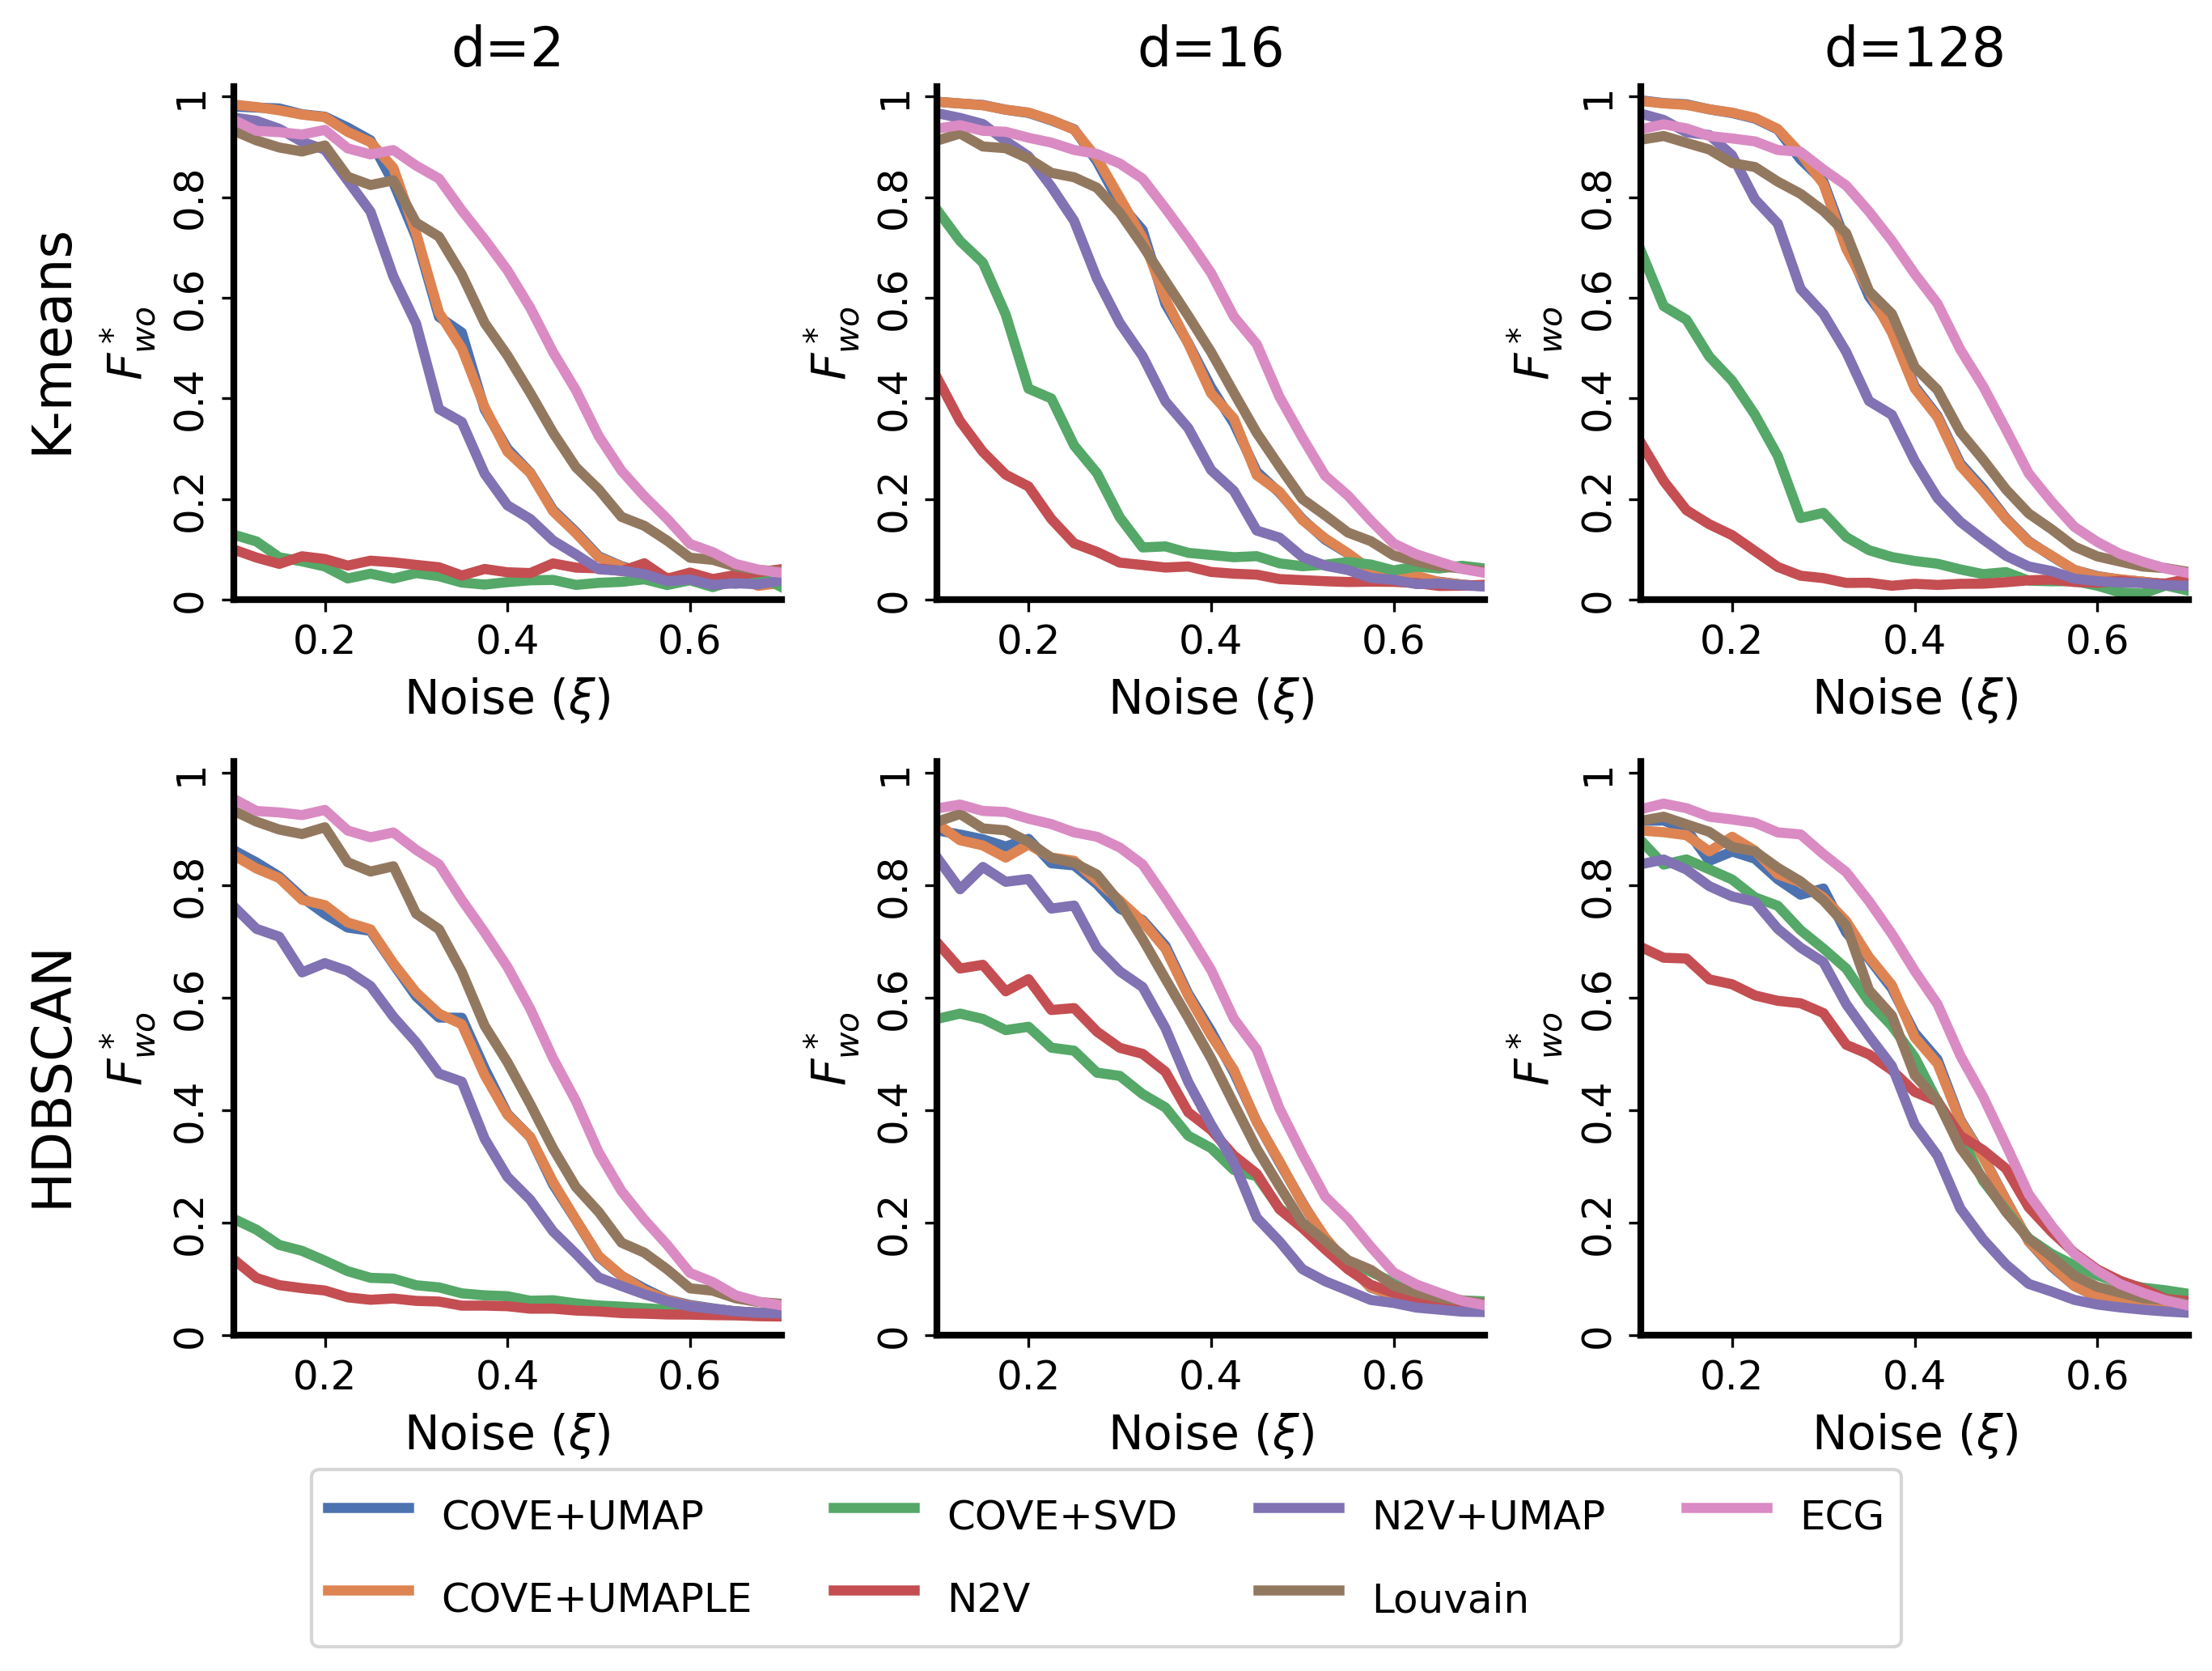

In [49]:
from matplotlib.colors import ListedColormap
pal = sns.color_palette("deep")

# plot results
performance2 = np.load("clustering_performance_dim2.npy")
means2 = np.mean(performance2, axis=3)

performance16 = np.load("clustering_performance_dim16.npy")
means16 = np.mean(performance16, axis=3)

performance128 = np.load("clustering_performance_dim128.npy")
means128 = np.mean(performance128, axis=3)


fig = plt.figure(constrained_layout=True, figsize=(9, 6), dpi=300)
axs = []
# create 2x3 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    # create 1x3 subplots per subfig
    axs.append(subfig.subplots(nrows=1, ncols=3))
axs = np.asarray(axs)

subfigs[0].supylabel("K-means", y=0.55, fontsize=16)
subfigs[1].supylabel("HDBSCAN", y=0.55, fontsize=16)

axs[0,0].set_title("d=2", fontsize=16)
axs[0,1].set_title("d=16", fontsize=16)
axs[0,2].set_title("d=128", fontsize=16)

for col, m in zip(range(3), [means2, means16, means128]):
    for row in range(2):
        for i in range(m.shape[1]):
            axs[row, col].plot(
                xis,
                m[row,i],
                label = methods[i],
                color = pal[i],
                lw = 3,
            )

for ax in axs.flatten():
    ax.set_ylim([0.0, 1.02])
    ax.set_xlim([np.min(xis), np.max(xis)])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], rotation=90, va='center')
    ax.tick_params(labelsize=12)

    ax.set_xlabel(r'Noise $(\xi)$', fontsize=14)
    ax.set_ylabel(r'$F^*_{wo}$', fontsize=14)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(2)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(
    handles,
    methods,
    bbox_to_anchor=[0.5, -0.06], 
    loc='center', 
    ncol=4,
    fancybox=True,
    handleheight=2.0,
    fontsize=12,
)
# #set_size(5,5)
# plt.show()

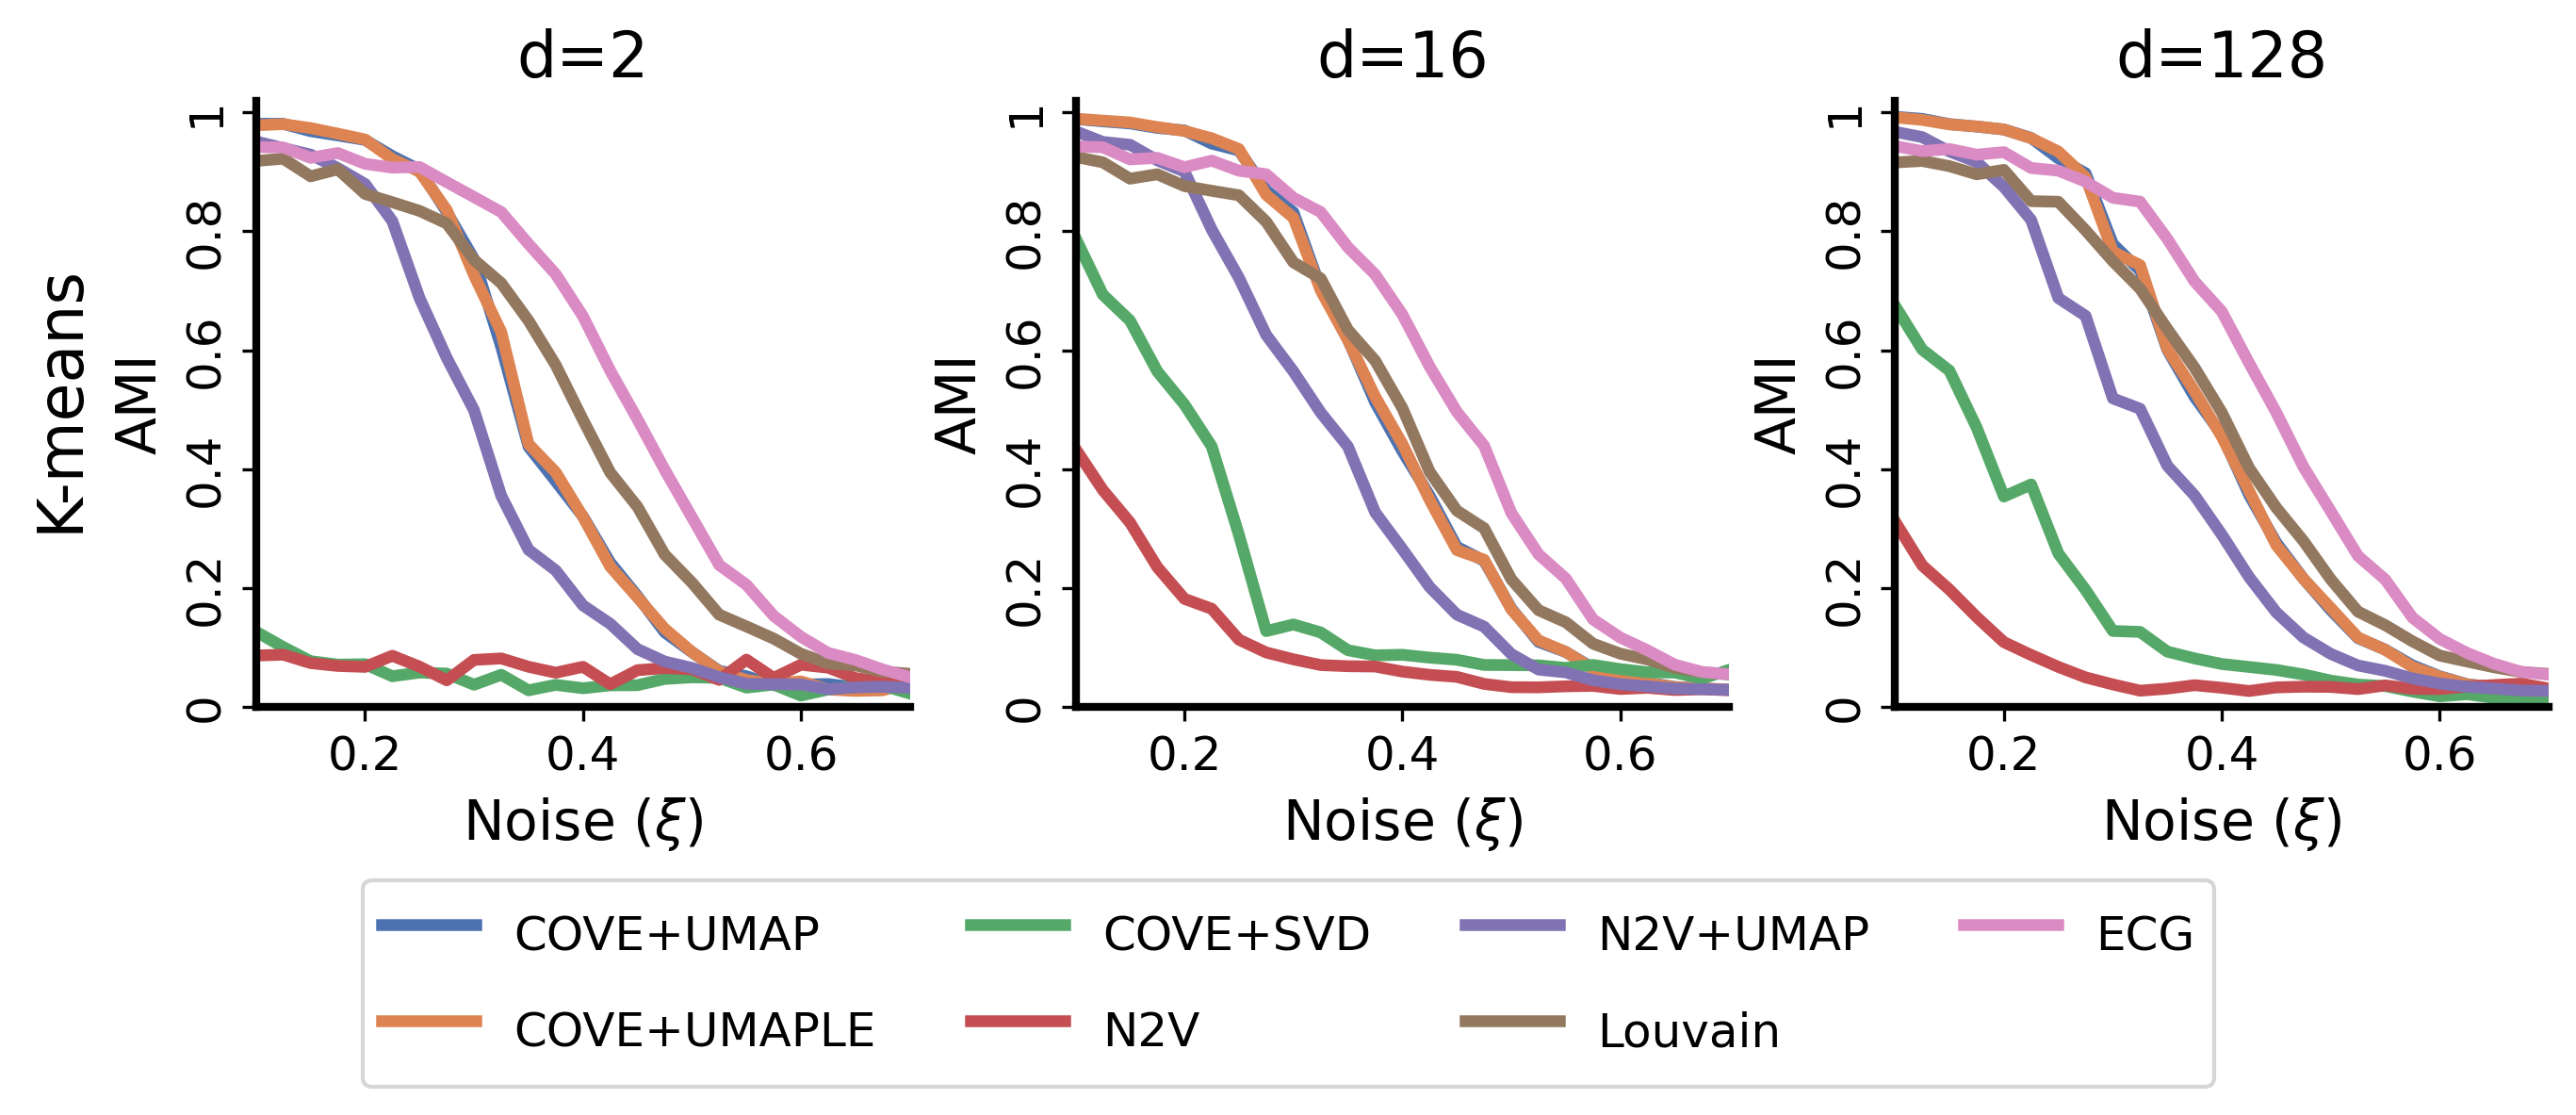

In [8]:
from matplotlib.colors import ListedColormap
pal = sns.color_palette("deep")

# plot results
performance2 = np.load("clustering_ami_dim2.npy")
means2 = np.mean(performance2, axis=3)

performance16 = np.load("clustering_ami_dim16.npy")
means16 = np.mean(performance16, axis=3)

performance128 = np.load("clustering_ami_dim128.npy")
means128 = np.mean(performance128, axis=3)


fig = plt.figure(constrained_layout=True, figsize=(9, 3), dpi=300)
axs = []
# create 2x3 subfigs
subfigs = [fig.subfigures(nrows=1, ncols=1)]
for row, subfig in enumerate(subfigs):
    # create 1x3 subplots per subfig
    axs.append(subfig.subplots(nrows=1, ncols=3))
axs = np.asarray(axs)

subfigs[0].supylabel("K-means", y=0.55, fontsize=16)

axs[0,0].set_title("d=2", fontsize=16)
axs[0,1].set_title("d=16", fontsize=16)
axs[0,2].set_title("d=128", fontsize=16)

for col, m in zip(range(3), [means2, means16, means128]):
    for row in range(1):
        for i in range(m.shape[1]):
            axs[row, col].plot(
                xis,
                m[row,i],
                label = methods[i],
                color = pal[i],
                lw = 3,
            )

for ax in axs.flatten():
    ax.set_ylim([0.0, 1.02])
    ax.set_xlim([np.min(xis), np.max(xis)])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], rotation=90, va='center')
    ax.tick_params(labelsize=12)

    ax.set_xlabel(r'Noise $(\xi)$', fontsize=14)
    ax.set_ylabel('AMI', fontsize=14)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(2)

handles, labels = axs[0,1].get_legend_handles_labels()
fig.legend(
    handles,
    methods,
    bbox_to_anchor=[0.5, -0.14], 
    loc='center', 
    ncol=4,
    fancybox=True,
    handleheight=2.0,
    fontsize=12,
)

# Real Data

In [7]:
def best_hdbscan(vectors, labels):
    clusterer = HDBSCAN()
    best = 0
    n_clusters = 0
    best_size = 0
    for min_size in trange(2, int(15*np.log2(vectors.shape[0]))):
        clusterer.min_cluster_size = min_size
        predict = clusterer.fit_predict(vectors)
        current = fstar(predict, labels)
        if current > best:
            best = current
            best_size = min_size
            n_clusters = np.max(predict)+1
    return best, best_size, n_clusters


In [8]:
# To use existing embeddings, run store_embeddings.py and load the files

# To generate each embedding as needed, comment out loading the files and uncomment
# the embedding step. Warning that this is fairly slow for the larger graphs.

graphs = ["football", "primary1", "primary2", "eu-core", "eurosis", "cora_small", "airport", "blogcatalog", "cora", "as"]
n_walks = 10
walk_len = 40
window_size=7
dim=16

data = []
runs = 10

np.random.seed(42)
#vectorizer = COVE(window_length=window_size, walks_per_node = n_walks, walk_length = walk_len)
louvain = sn.clustering.Louvain(shuffle_nodes=True)
ecg = ECG()

for i, graph in enumerate(graphs):
    for run in range(runs):
        if run < 2 or graph != "as":
            continue
        print(graph, f"{run+1}/{runs}")
        adjacency, labels = load_graph(graph)

        high = sp.load_npz(f"embeddings/{graph}_cove_{run}.npz")
        #low = UMAP(metric="hellinger").fit_transform(high)
        low = np.load(f"embeddings/{graph}_coveumap_d{dim}_{run}.npy")
        gc.collect()
        fs, ms, nc = best_hdbscan(low, labels)
        data.append({"method":"COVE+UMAP", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":ms})
        
        #low = UMAPLE(dimension=2, metric="hellinger").fit_transform(high, adjacency)
        low = np.load(f"embeddings/{graph}_coveumaple_d{dim}_{run}.npy")
        gc.collect()
        fs, ms, nc = best_hdbscan(low, labels)
        data.append({"method":"COVE+UMAPLE", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":ms})

        low = TruncatedSVD(n_components=dim).fit_transform(high)
        gc.collect()
        fs, ms, nc = best_hdbscan(low, labels)
        data.append({"method":"COVE+SVD", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":ms})

        # WARNING this method is extremely slow and memory intensive for large graphs.
        # den = np.asarray(high.todense())
        # low = ClassicalMDS(n_components=dim).fit_transform(den)
        # gc.collect()
        # fs = best_hdbscan(low, labels)
        # data.append({"method":"COVE+MDS", "name":graph, "run":run, "FSTAR":fs})

        low = np.load(f"embeddings/{graph}_n2v_d{dim}_{run}.npy")
        gc.collect()
        fs, ms, nc = best_hdbscan(low, labels)
        data.append({"method":"N2V", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":ms})

        #high = np.load(f"embeddings/{graph}_n2v_d128.npy")
        #low = UMAP(metric="cosine").fit_transform(high)
        low = np.load(f"embeddings/{graph}_n2vumap_d{dim}_{run}.npy")
        gc.collect()
        fs, ms, nc = best_hdbscan(low, labels)
        data.append({"method":"N2V+UMAP", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":ms})

        predict = louvain.fit_predict(adjacency)
        fs = fstar(predict, labels)
        nc = np.max(predict)+1
        nofs = fstar(predict, labels, drop_outliers="c1")
        data.append({"method":"Louvain", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":np.nan})

        predict = ecg.fit_predict(adjacency)
        fs = fstar(predict, labels)
        nc = np.max(predict)+1
        data.append({"method":"ECG", "name":graph, "run":run, "FSTAR":fs, "N Clusters":nc, "MS":np.nan})
        
        df = pd.DataFrame(data)
        df.to_pickle(f"clustering_real_t_dim{dim}.pkl")

as 3/10


100%|██████████| 216/216 [02:31<00:00,  1.42it/s]


as 4/10


100%|██████████| 216/216 [02:23<00:00,  1.51it/s]


as 5/10


 75%|███████▌  | 163/216 [01:36<00:36,  1.44it/s]/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 216/216 [02:17<00:00,  1.57it/s]


as 6/10


100%|██████████| 216/216 [02:17<00:00,  1.57it/s]


as 7/10


100%|██████████| 216/216 [02:44<00:00,  1.31it/s]


as 8/10


100%|██████████| 216/216 [02:44<00:00,  1.32it/s]


as 9/10


100%|██████████| 216/216 [02:26<00:00,  1.47it/s]


as 10/10


100%|██████████| 216/216 [02:52<00:00,  1.25it/s]


In [3]:
#df = pd.DataFrame(data)
df = pd.read_pickle("clustering_real_t_dim16.pkl")
df

,method,name,run,FSTAR,N Clusters,MS
0,COVE+UMAP,football,0,0.840404,12,2.0
1,COVE+UMAPLE,football,0,0.843856,12,2.0
2,COVE+SVD,football,0,0.858391,10,6.0
3,N2V,football,0,0.791861,9,4.0
4,N2V+UMAP,football,0,0.721793,9,3.0
...,...,...,...,...,...,...
639,COVE+SVD,as,1,0.164713,21,75.0
640,N2V,as,1,0.175352,47,37.0
641,N2V+UMAP,as,1,0.276121,91,53.0
642,Louvain,as,1,0.300955,29,NaN


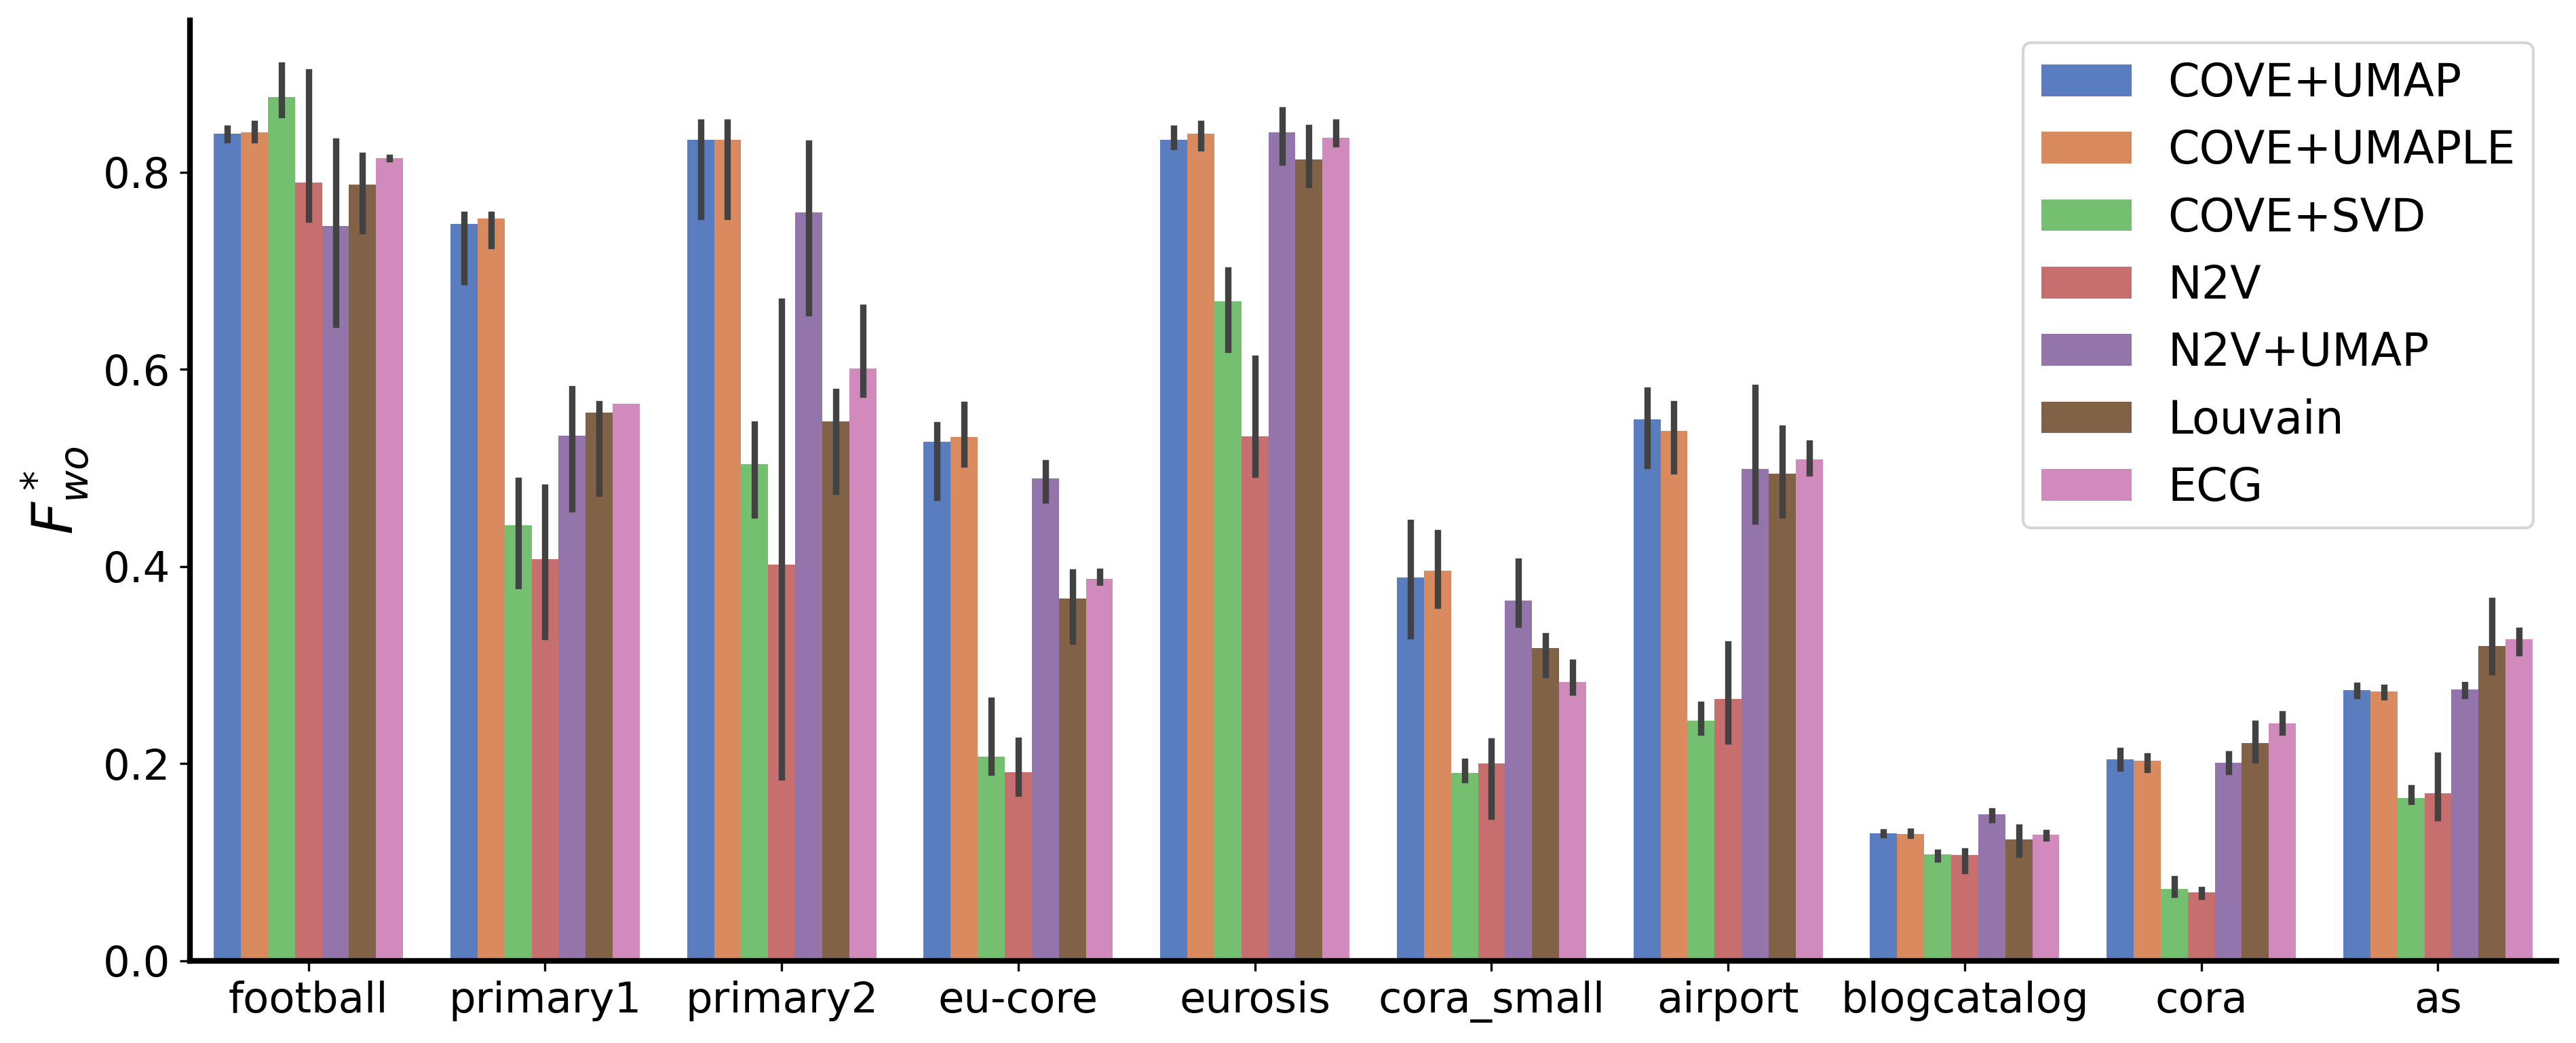

In [9]:
fig, ax = plt.subplots(figsize=(15,6), dpi=300)
sns.barplot(df, x="name", y="FSTAR", hue="method", ax=ax, palette="muted", errorbar=("pi", 100))
ax.set_ylabel(r"$F^*_{wo}$", fontsize=20)

# Decorations
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.legend(fancybox=True, fontsize=16)

In [19]:
df.groupby("name")["MS"].max()

name
airport        162.0
as             165.0
blogcatalog    125.0
cora           120.0
cora_small     104.0
eu-core         20.0
eurosis         36.0
football         7.0
primary1        13.0
primary2        13.0
Name: MS, dtype: float64

In [20]:
for n in graphs:
    adj, lab = load_graph(n)
    print(n, int(15*np.log2(adj.shape[0])))

football 102
primary1 118
primary2 118
eu-core 149
eurosis 154
cora_small 171
airport 172
blogcatalog 199
cora 217
as 218
